# Can asymmetric stop-loss / stop-win point beat the market?

In this notebook, I am trying to answer this question. In a liquid market, can you beat the index if you set some asymmetric stop-loss and stop-win points? Is it possible that by doing so, you can
- take enough small profit that can offset the loss (small stop win and large stop loss) or, 
- catch some large positive movement that can offset many small loss (large stop win and small stop loss)? 

## Workflow
I am going to 
- Load SPY minute data from 3rd party API
- Check if minute return follows some distribution
- Check if minute return is at least symmetric
- Roughly test the two strategies mentioned above


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import numpy as np


plt.style.use('ggplot')
%matplotlib inline

## Dataset 
I am going to use SPY minute level data for past 30 days. The data is provided by IEX api

In [2]:
# Download minute data from IEX
# They only provide minute level data for last 30 calendar days

today = pd.datetime.today()
start_point = today - pd.Timedelta(days=30)
date_range = pd.date_range(start_point, today, freq=BDay())

buff = [pd.read_json("https://api.iextrading.com/1.0/stock/spy/chart/date/{}".format(item.strftime("%Y%m%d"))) for item in date_range]
buff = [item for item in buff if len(item) > 0]

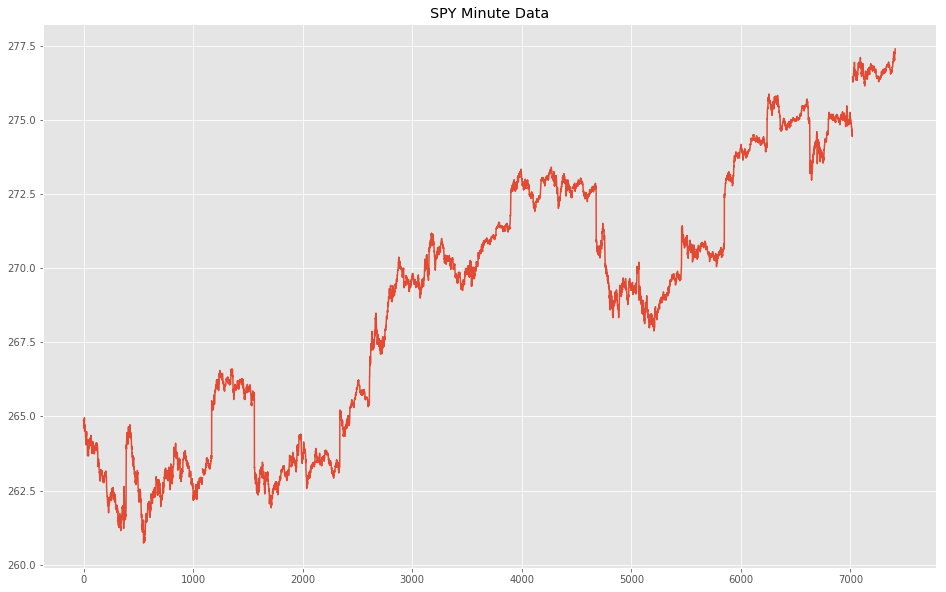

In [3]:
df = pd.concat(buff)
df = df[["date", "minute","open", "high", "low", "close", "volume"]]
df["date"] = df["date"].apply(lambda x: str(x)).apply(lambda x: x[:4] + "-" + x[4:6] + "-" + x[6:8])
df["date"] = pd.to_datetime(df["date"])
df[["close"]].reset_index()["close"].plot(title="SPY Minute Data", figsize=(16,10))

## Normality check

The high Kurtosis suggests that simple percentage return doesn't follow normal distribution

In [4]:
# Check return distribution
df["change"] = df["close"].pct_change().fillna(0) * 100
summary = {
    "mean": df["change"].mean(),
    "std": df["change"].std(),
    "skew": df["change"].skew(),
    "kurtosis": df["change"].kurtosis()
}
pd.DataFrame(summary, index=[0])

,mean,std,skew,kurtosis
0,0.000631,0.040156,0.288418,111.04957


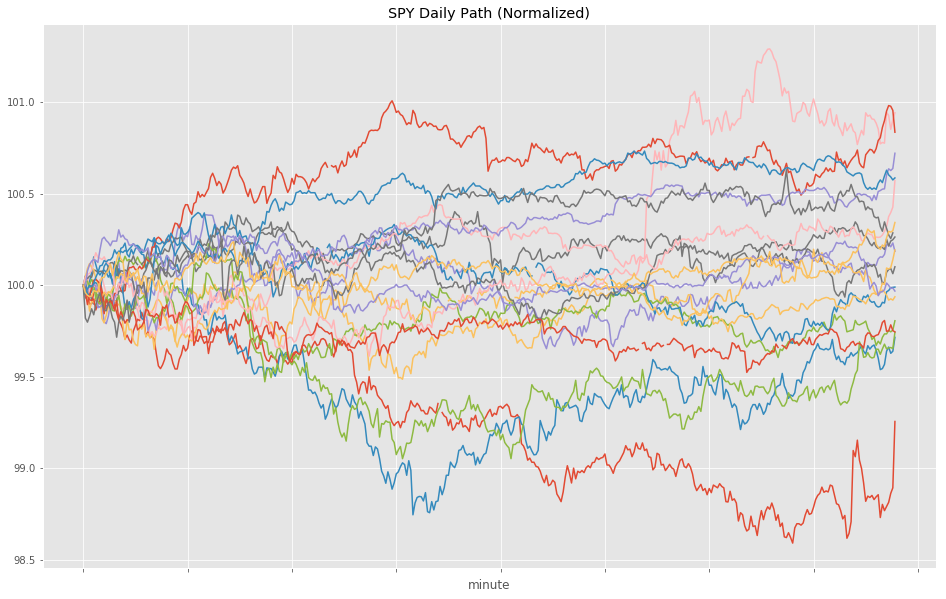

In [5]:
# plot daily path (normalized)
daliy_p_table = df[["minute", "date", "close"]].pivot("minute", "date", "close")
daliy_p_table = daliy_p_table / daliy_p_table.iloc[0, :] * 100
daliy_p_table.plot(title="SPY Daily Path (Normalized)", figsize=(16,10), legend=False)

## Lognormal check

By looking at the path plot, it's tempting to think maybe the process is brownian motion. However, the stats suggests that it's not brownian motion either. 

In [6]:
# See if it's lognormal
df["ln_close"] = np.log(df["close"])
summary = {
    "mean": df["ln_close"].mean(),
    "std": df["ln_close"].std(),
    "skew": df["ln_close"].skew(),
    "kurtosis": df["ln_close"].kurtosis()
}
pd.DataFrame(summary, index=[0])

,mean,std,skew,kurtosis
0,5.594827,0.016852,-0.103631,-1.232624


## Symmetricity check
In order for our strategy to make sense, we need to at least make sure the return is roughtly symmetric. Fortunately, this is satisfied.

In [7]:
# daily return / std by positive or negative
daily_return = df[["date", "minute", "close"]].pivot("minute", "date", "close")
daily_return = daily_return / daily_return.iloc[0, :]
daily_return = daily_return - 1
positive_daily_return = daily_return[daily_return > 0].values.flatten()
positive_daily_return = positive_daily_return[~np.isnan(positive_daily_return)]
negative_daily_return = daily_return[daily_return < 0].values.flatten()
negative_daily_return = negative_daily_return[~np.isnan(negative_daily_return)]
result_date = {
    "Mean": [positive_daily_return.mean(), negative_daily_return.mean()],
    "Std": [positive_daily_return.std(), negative_daily_return.std()],
}
pd.DataFrame(result_date, index=["Positive", "Negative"])

,Mean,Std
Positive,0.002946,0.002413
Negative,-0.003054,0.002947


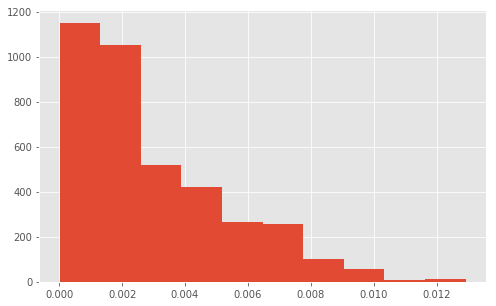

In [13]:
pd.Series(positive_daily_return).hist(figsize=(8,5))

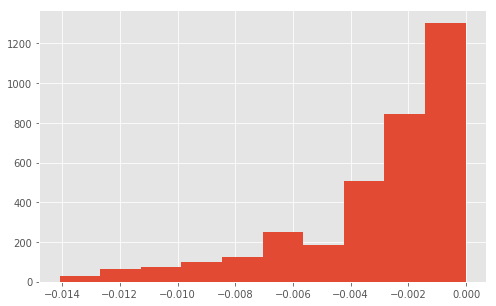

In [14]:
pd.Series(negative_daily_return).hist(figsize=(8,5))

## Stategy test
First, let's set stop-loss and stop-win equal to each other. The result suggests that this setting and enhance the performance a little. However, given it needs to do 2 trades everyday, in reality, the small alpha potion will be eaten by commissions easily.

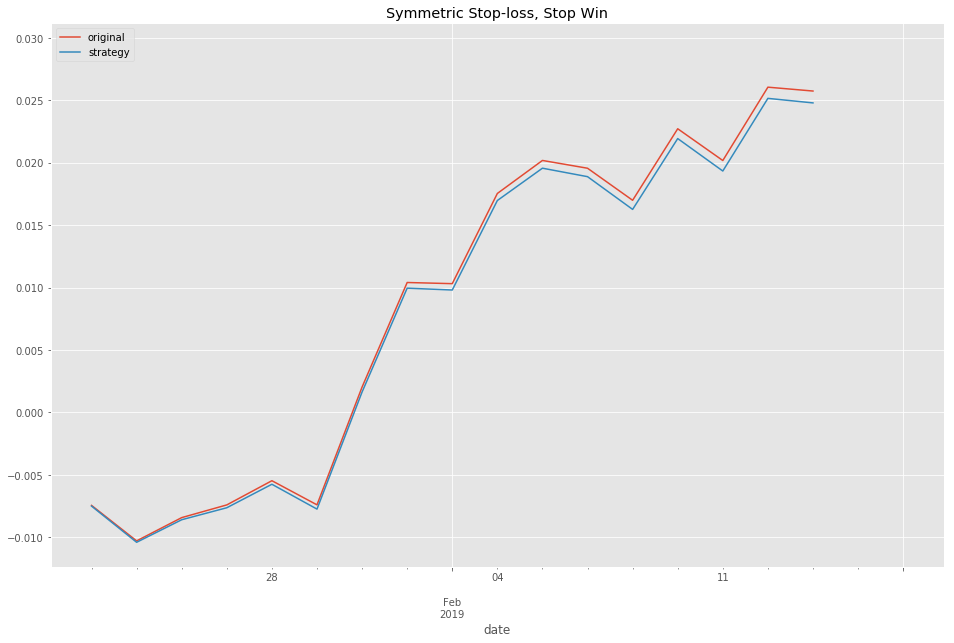

In [21]:
stop_loss = -0.02
stop_win = 0.02

def trading_logic(arr, stop_loss, stop_win, commission=0.015):
    start_value = arr.iloc[0]
    commission_cut = commission / start_value
    for item in arr.values:
        pl = item / start_value - 1
        if pl < stop_loss:
            return pl - commission_cut
        elif pl > stop_win:
            return pl - commission_cut
    return arr.iloc[-1] / arr.iloc[0] - 1 - commission_cut

original = df[["date", "close"]].groupby("date").agg(trading_logic, stop_loss=-1, stop_win=99, commission=0)
result = df[["date", "close"]].groupby("date").agg(trading_logic, stop_loss=stop_loss, stop_win=stop_win)

result = pd.concat([original, result], axis=1)
result.columns = ["original", "strategy"]
result[["original", "strategy"]].cumsum().plot(title="Symmetric Stop-loss, Stop Win", figsize=(16,10))

## Small Stop loss, Large Stop win
We hope to profit by taking large positive movement to offset a series of small negative stop loss. Unfortunately, this doesn't work.

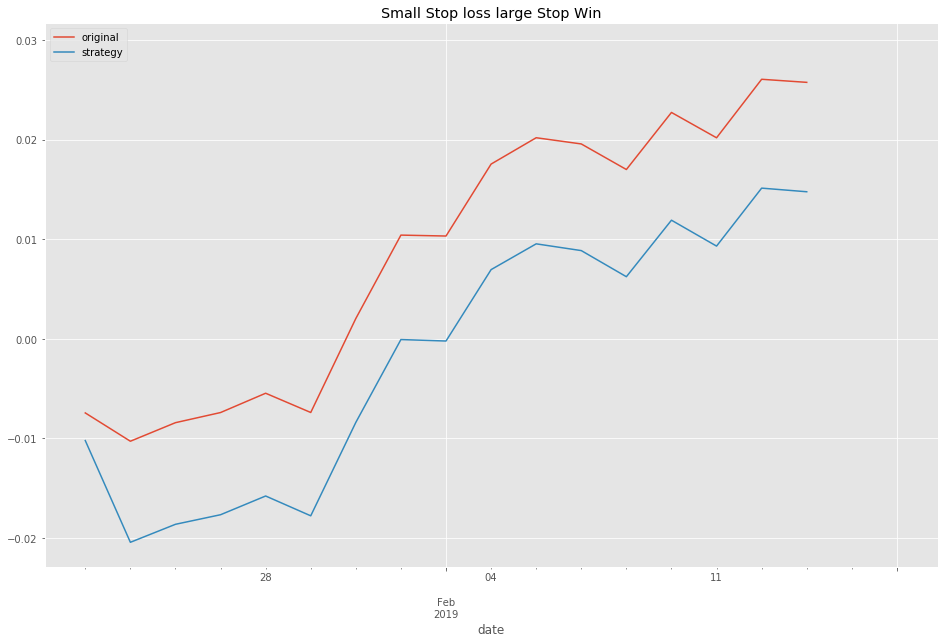

In [23]:
stop_loss = -0.01
stop_win = 0.02
result = df[["date", "close"]].groupby("date").agg(trading_logic, stop_loss=stop_loss, stop_win=stop_win)

result = pd.concat([original, result], axis=1)
result.columns = ["original", "strategy"]
result[["original", "strategy"]].cumsum().plot(title="Small Stop loss large Stop Win", figsize=(16,10))

## Large Stop loss, small stop win
We hope to profit by taking a lot of small positive movement that can offset relatively large loss. The result looks similar to the first one. Again, the alpha is too small that can vanish easily when considering commission.

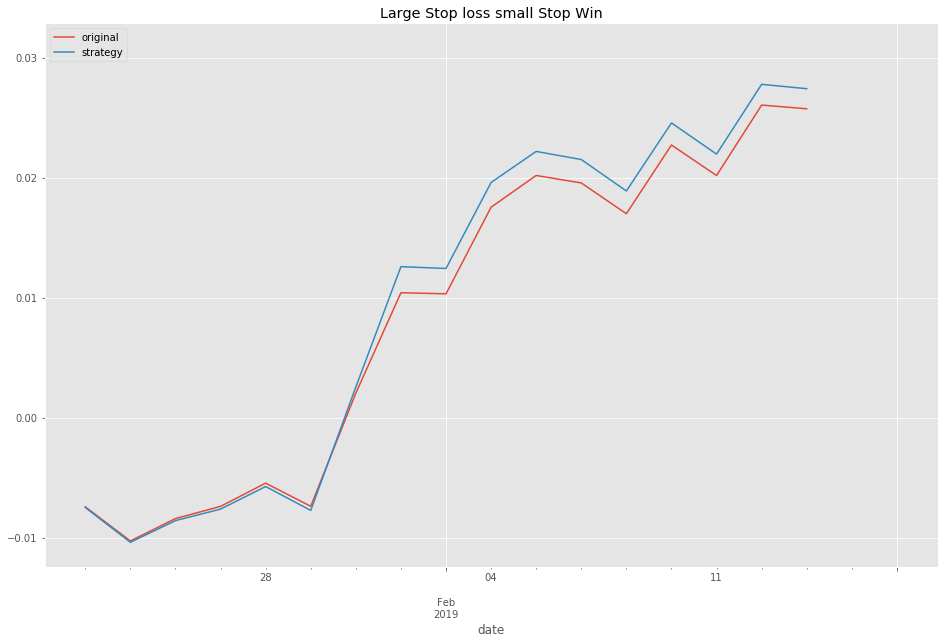

In [24]:
stop_loss = -0.02
stop_win = 0.01
result = df[["date", "close"]].groupby("date").agg(trading_logic, stop_loss=stop_loss, stop_win=stop_win)

result = pd.concat([original, result], axis=1)
result.columns = ["original", "strategy"]
result[["original", "strategy"]].cumsum().plot(title="Large Stop loss small Stop Win", figsize=(16,10))

## Conclusion
We cannot make significant profit by simply setting stop loss and stop win points. We may enhance the performance a little bit, but the real performance may be worse because of commission. 